In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import cv2
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Load annotation file

In [17]:
root_dir = Path('./raw_data')
scene = 'library'
sequence = '1029_2'
camera = 'Camera_5_0'

In [18]:
annotation_file_path = root_dir / scene / sequence / (camera + '.pkl')
annotation = joblib.load(annotation_file_path)

### Data structure

Annotation data are stored in a python dictionary which contains following entories. 

- R_cam2w, t_cam2w: Extrinsics of the surveillance camera. (Camera coordinate to world coordinate)
- keypoints2d: 2D body joints obtained with the OpenPose model
- chest, head, gaze: 3D unit vectors representing chest, head, and gaze directions in the *camera coordinate system*. 


### Demo: Draw gaze, head, and body orientations

In [19]:
frame_index = 0

image_file_path = root_dir / scene / sequence / camera / f'{frame_index:06}.jpg'
image = cv2.imread(str(image_file_path))

gaze_dir = annotation['gaze']['direction'][frame_index]
head_dir = annotation['head']['direction'][frame_index]
body_dir = annotation['chest']['direction'][frame_index]

gaze_2d = gaze_dir[:2] / np.linalg.norm(gaze_dir[:2])
head_2d = head_dir[:2] / np.linalg.norm(head_dir[:2])
body_2d = body_dir[:2] / np.linalg.norm(body_dir[:2])



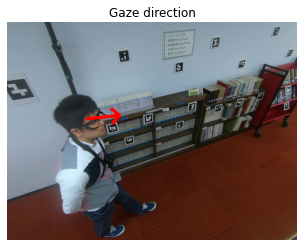

In [25]:
head_center = (750, 900)
des = (head_center[0] + int(gaze_2d[0]*300), int(head_center[1] + gaze_2d[1]*300))
image_gaze = cv2.arrowedLine(image.copy(), head_center, des, (0, 0, 255), 30, tipLength=0.3)
plt.imshow(image_gaze[:, :, ::-1])
plt.title('Gaze direction')
plt.axis('off')
plt.show()

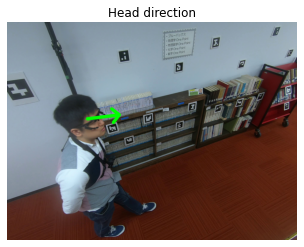

In [27]:
head_center = (750, 900)
des = (head_center[0] + int(head_2d[0]*300), int(head_center[1] + head_2d[1]*300))
image_head = cv2.arrowedLine(image.copy(), head_center, des, (0, 255, 0), 30, tipLength=0.3)
plt.imshow(image_head[:, :, ::-1])
plt.title('Head direction')
plt.axis('off')
plt.show()

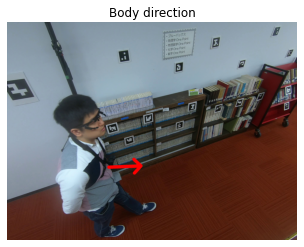

In [31]:
body_center = (950, 1350)
des = (body_center[0] + int(body_2d[0]*300), int(body_center[1] + body_2d[1]*300))
image_body = cv2.arrowedLine(image.copy(), body_center, des, (0, 0, 255), 30, tipLength=0.3)
plt.imshow(image_body[:, :, ::-1])
plt.title('Body direction')
plt.axis('off')
plt.show()

### Demo: Triangulation

In [6]:
# Load intrinsics

K = np.load('./raw_data/intrinsics.npz')['cam_mat']
print(K)

[[1.42379170e+03 0.00000000e+00 1.30792281e+03]
 [0.00000000e+00 1.42731475e+03 1.01533871e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


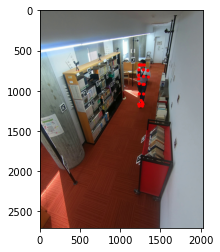

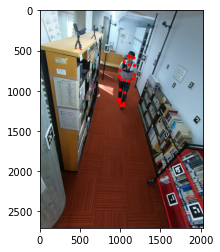

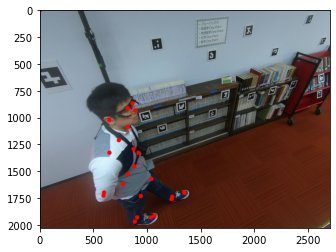

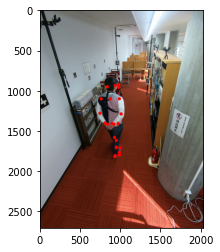

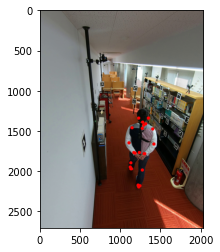

In [25]:
cameras = ['Camera_1_0', 'Camera_2_0', 'Camera_3_0', 'Camera_4_0', 'Camera_5_0', 'Camera_6_0', 'Camera_7_0', 'Camera_8_0']
frame_index = 0



camera_extrinsics = []
keypoints = []
for camera in cameras:
    annotation_file_path = root_dir / scene / sequence / (camera + '.pkl')
    if not annotation_file_path.exists():
        continue

    annotation = joblib.load(annotation_file_path)

    keypoint = annotation['keypoints2d'][frame_index][:, :2].astype(np.int64)

    if np.sum(keypoint) == 0:
        continue

    image_file_path = root_dir / scene / sequence / camera / f'{frame_index:06}.jpg'
    image = cv2.imread(str(image_file_path))

    # Draw 2D body joints
    image_draw = image.copy()
    for k in keypoint:
        image_draw = cv2.circle(image_draw, tuple(k), 20, (0, 0, 255), -1)
    
    plt.imshow(image_draw[:, :, ::-1])
    plt.show()

    R_cam2w = annotation['R_cam2w']
    t_cam2w = annotation['t_cam2w']
    camera_extrinsics.append(np.hstack([K@R_cam2w.T, (-K@R_cam2w.T @ t_cam2w)[:, None]]))
    keypoints.append(np.hstack((keypoint, np.ones((keypoint.shape[0], 1)))))

keypoints = np.stack(keypoints).transpose(1,0,2)

In [26]:
# https://gist.github.com/davegreenwood/e1d2227d08e24cc4e353d95d0c18c914

def triangulate_nviews(P, ip):
    """
    Triangulate a point visible in n camera views.
    P is a list of camera projection matrices.
    ip is a list of homogenised image points. eg [ [x, y, 1], [x, y, 1] ], OR,
    ip is a 2d array - shape nx3 - [ [x, y, 1], [x, y, 1] ]
    len of ip must be the same as len of P
    """
    if not len(ip) == len(P):
        raise ValueError('Number of points and number of cameras not equal.')
    n = len(P)
    M = np.zeros([3*n, 4+n])
    for i, (x, p) in enumerate(zip(ip, P)):
        M[3*i:3*i+3, :4] = p
        M[3*i:3*i+3, 4+i] = -x
    V = np.linalg.svd(M)[-1]
    X = V[-1, :4]
    return X / X[3]

keypoints_3d = []
for k in keypoints:
    p3d = triangulate_nviews(camera_extrinsics, k)
    keypoints_3d.append(p3d)
keypoints_3d = np.stack(keypoints_3d)

In [27]:
x = keypoints_3d[:, 0]
y = keypoints_3d[:, 1]
z = keypoints_3d[:, 2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')])
fig.show()